### Processing Clinical Data

In [18]:
import os
import glob
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')
np.random.seed(123)

In [2]:
data = pd.read_csv('./clinical_subset.csv') #subset of patients with genetic data only

<Axes: >

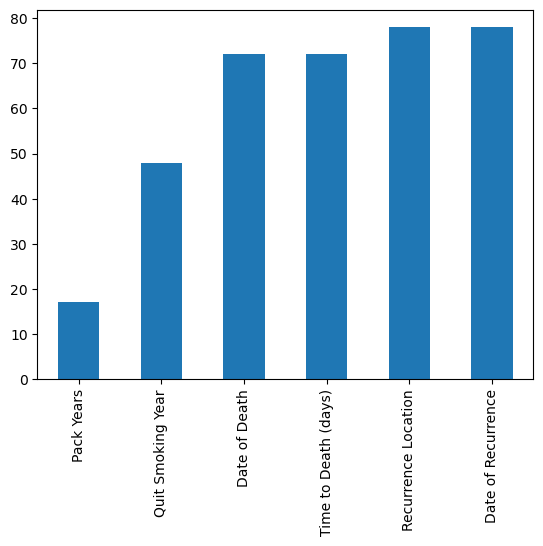

In [5]:
#find columns with missing values
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [6]:
data['Pack Years'] = data['Pack Years'].astype(float)

#continuous columns with NA values
columns_to_fill = ['Pack Years', 'Quit Smoking Year', 'Time to Death (days)']

# Fill NA values in the specified columns with their respective mean values
for column in columns_to_fill:
    data[column].fillna(data[column].mean(), inplace=True)

#categorical columns
columns_with_placeholder = ['Recurrence Location']

for column in columns_with_placeholder:
    mode_val = data[column].mode()[0]  # Get the most frequent category
    data[column].fillna(mode_val, inplace=True)

#date columns
data['Date of Recurrence'].fillna("Unkown", inplace=True)
data['Date of Death'].fillna("Unkown", inplace=True)

In [7]:
#map target
histology_mapping = {'Adenocarcinoma': 0, 'Squamous cell carcinoma': 1, 'NSCLC NOS (not otherwise specified)':0}

# Applying the mapping to the DataFrame
data['Histology'] = data['Histology'].map(histology_mapping)

In [8]:
#encode GG_mapping to mean value
GG_mapping = {'0%': 0, '50 - 75%': 62.5, '25 - 50%':37.5, '75 - < 100%':87.5, '>0 - 25%':12.5, '100%':100, 'Not Assessed':0}
data['%GG'] = data['%GG'].map(GG_mapping)

In [9]:
#drop date columns
list_delete_cols = ['Quit Smoking Year', 'Date of Recurrence', 'Date of Last Known Alive', 'Date of Death', 'CT Date', 'PET Date']
data.drop(list_delete_cols, axis=1, inplace=True)

In [10]:
#encode categorical columns
label_encoder = LabelEncoder()

# Columns to be encoded
columns_to_encode = data.select_dtypes(include=[object]).columns.tolist()
columns_to_encode = [col for col in columns_to_encode if col != "Case ID"]
#columns_to_encode = ['Age at Histological Diagnosis', 'Histopathological Grade','Smoking status', 'Pathological T stage', 'Pathological N stage', 'Gender', 'Tumor Location (choice=RUL)', 'Recurrence Location', 'Tumor Location (choice=RLL)', 'Tumor Location (choice=LUL)', 'Tumor Location (choice=LLL)', 'Tumor Location (choice=L Lingula)', 'Tumor Location (choice=Unknown)', 'Pathological M stage', 'EGFR mutation status', 'Recurrence','KRAS mutation status', 'ALK translocation status', 'Ethnicity', 'Pleural invasion (elastic, visceral, or parietal)', 'Lymphovascular invasion', 'Survival Status', 'Adjuvant Treatment', 'Chemotherapy', 'Radiation', 'Recurrence', 'Recurrence Location', 'Tumor Location (choice=RML)']

# Apply LabelEncoder to categorical columns
for column in columns_to_encode:
    data[column] = label_encoder.fit_transform(data[column])

In [13]:
def display_correlation_matrix(data):
	""" Displays a correlation matrix for a dataset """
	corr = data.corr()
	mask = np.triu(np.ones_like(corr, dtype=bool))
	f, ax = plt.subplots(figsize=(50, 50))
	cmap = sns.diverging_palette(20, 230, as_cmap=True)
	sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
	            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})

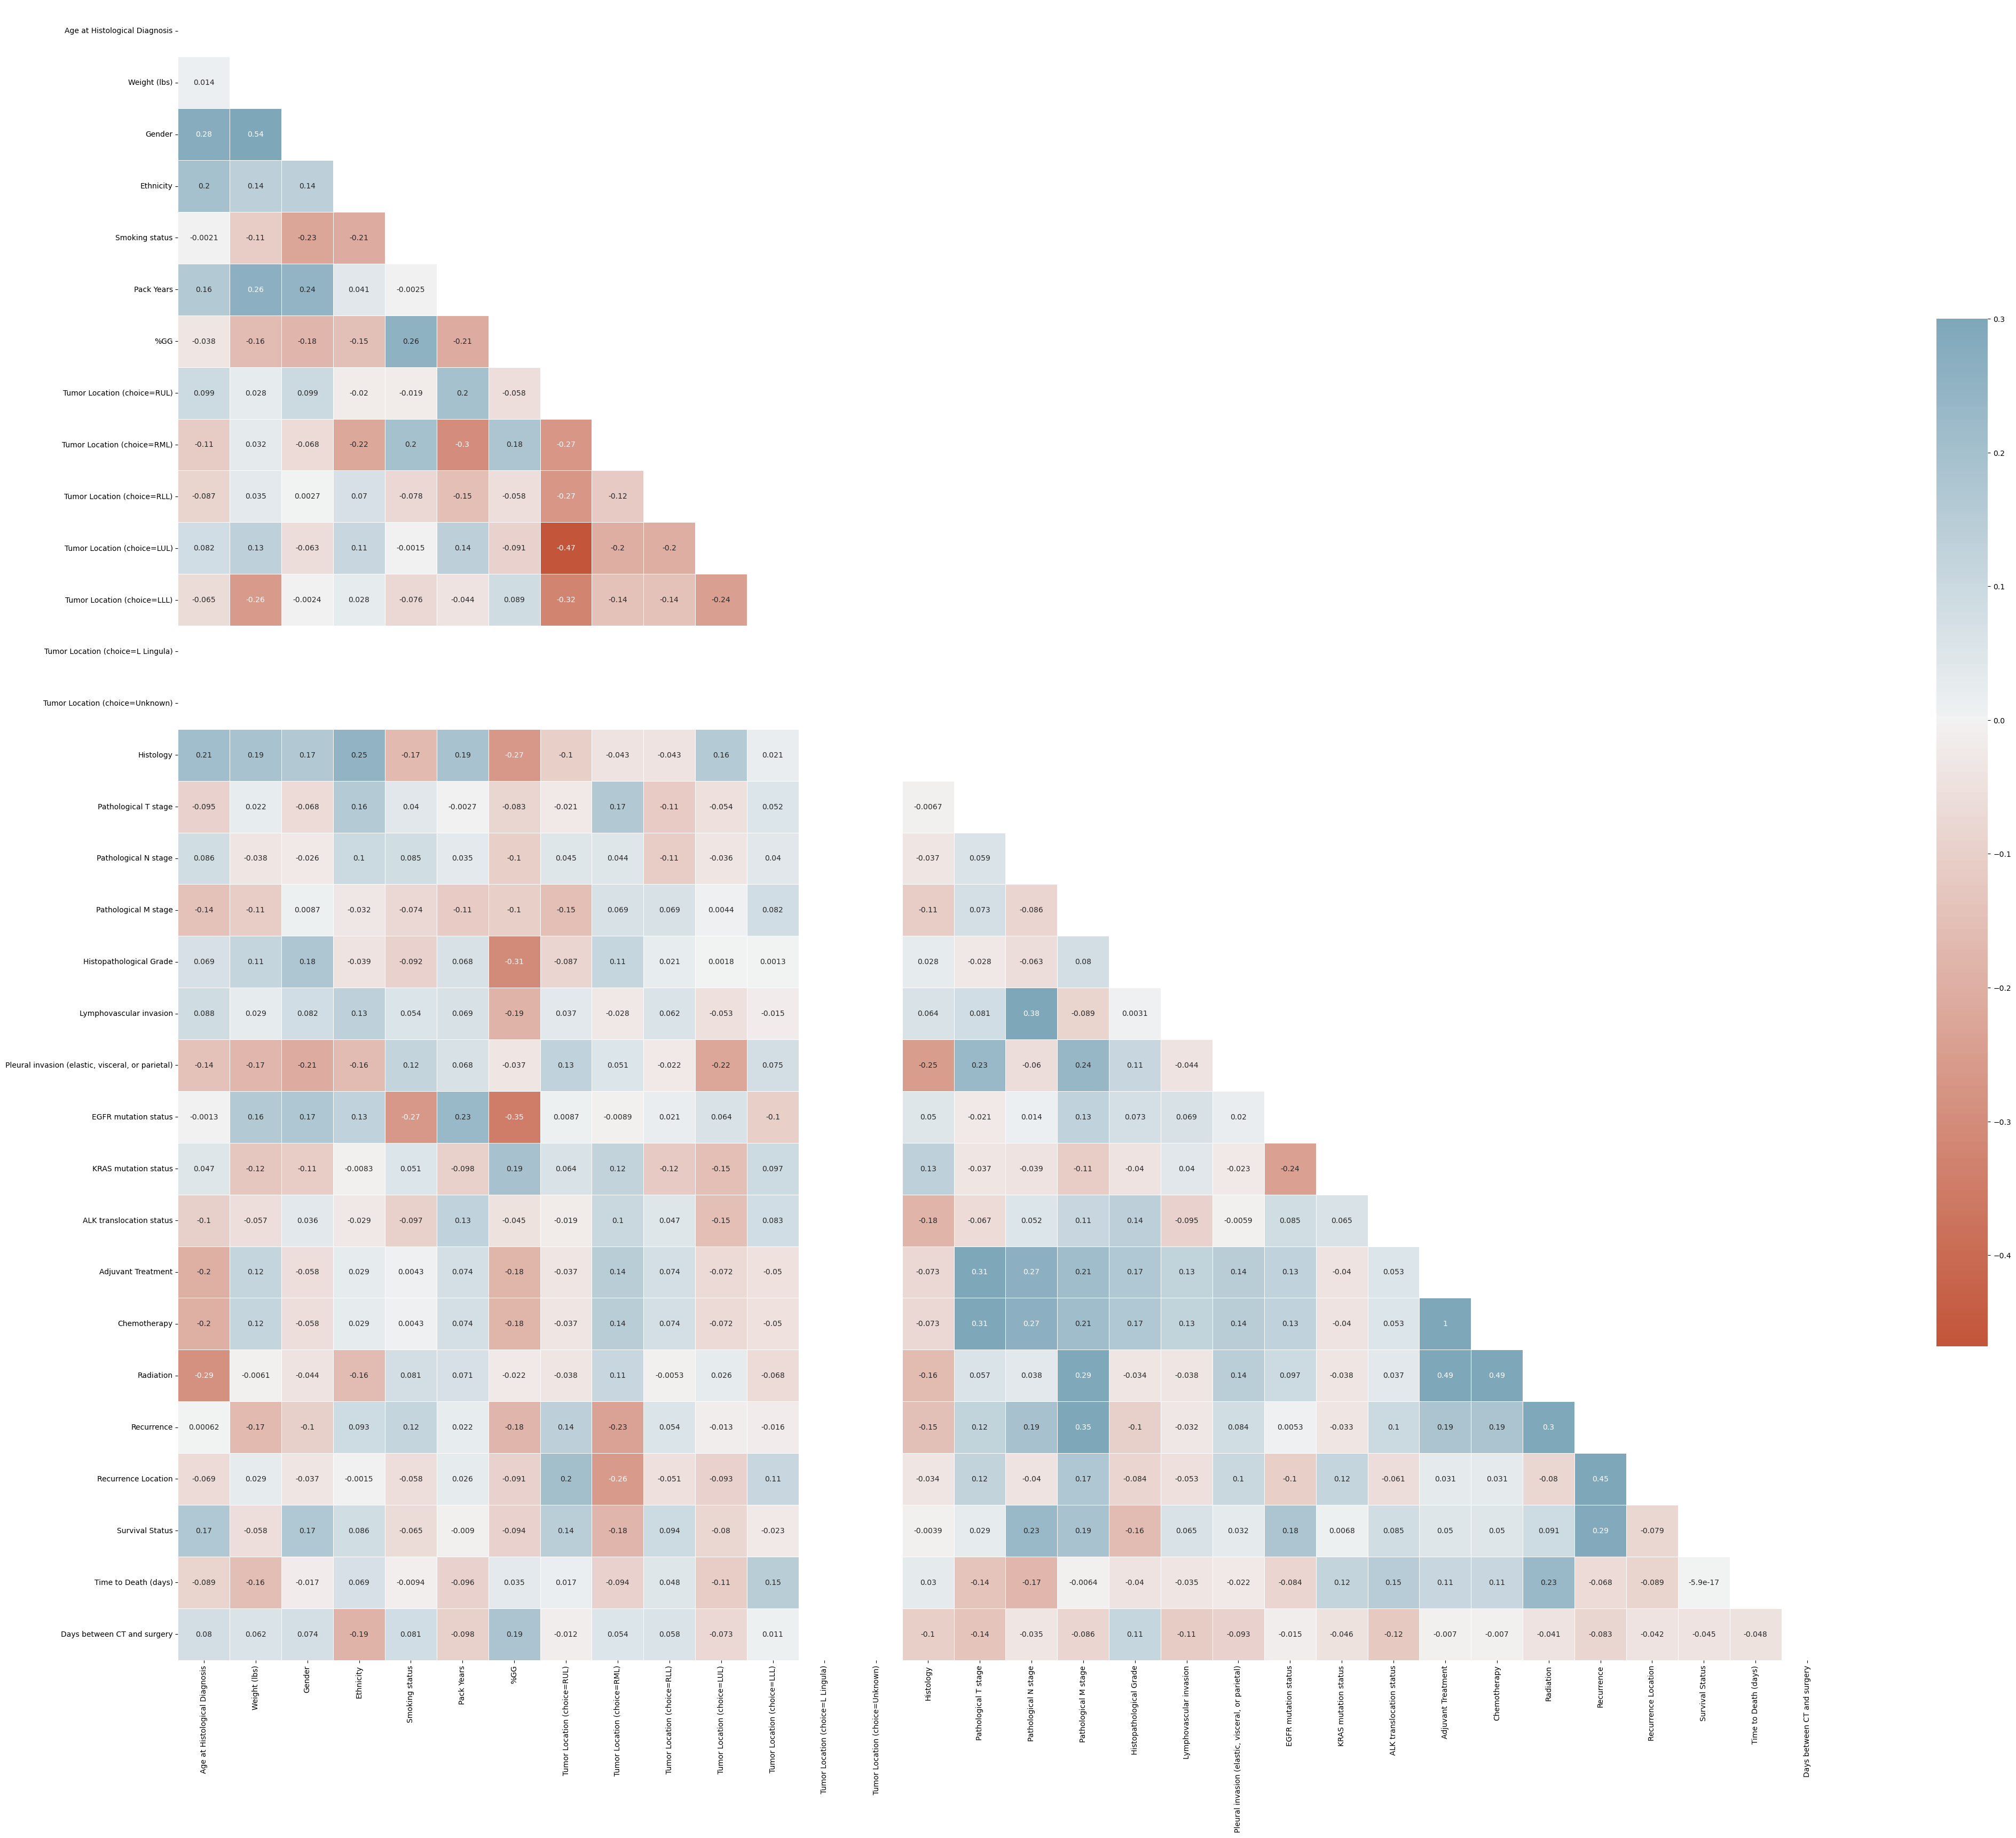

In [14]:
display_correlation_matrix(data.drop(['Case ID'], axis=1))

<Axes: title={'center': 'Histology'}>

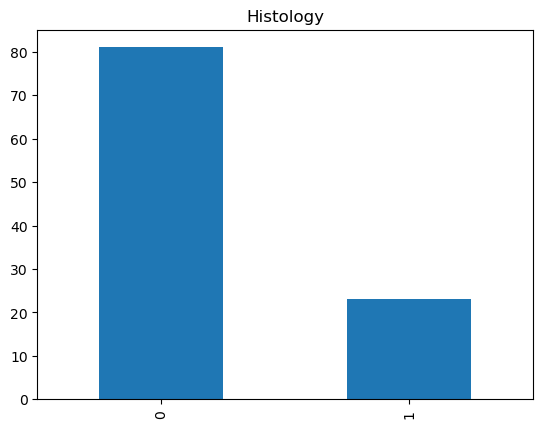

In [16]:
#class balance
data['Histology'].value_counts().plot(kind='bar', title='Histology')

In [33]:
#split data to train and test
X_train, X_test = train_test_split(data, test_size=0.4, random_state=73, stratify=data['Histology'])

In [34]:
X = X_train.drop(['Case ID','Histology'], axis=1)
y = X_train['Histology']

sm = SMOTE(random_state=73)

# Fit and apply the transform
X_resampled, y_resampled = sm.fit_resample(X, y)
rows_to_drop = X_resampled.index[-13:]  # Get the last 14 indices
X_resampled = X_resampled.drop(rows_to_drop)
rows_to_drop = y_resampled.index[-13:]  # Get the last 14 indices
y_resampled = y_resampled.drop(rows_to_drop)

In [35]:
#concatenate to dataframe
X_resampled_train = pd.DataFrame(X_resampled, columns=X.columns)
X_resampled_train['Histology'] = y_resampled

<Axes: title={'center': 'Histology'}>

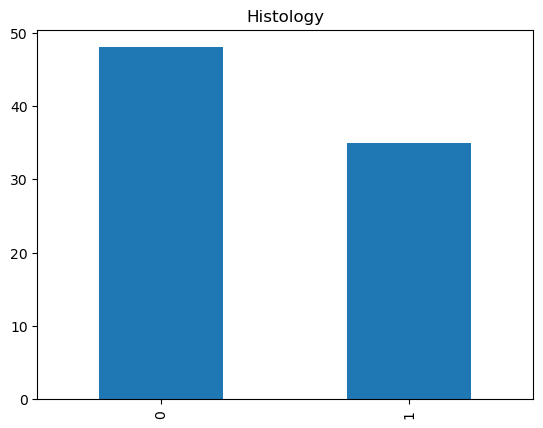

In [36]:
X_resampled_train['Histology'].value_counts().plot(kind='bar', title='Histology')

<Axes: title={'center': 'Histology'}>

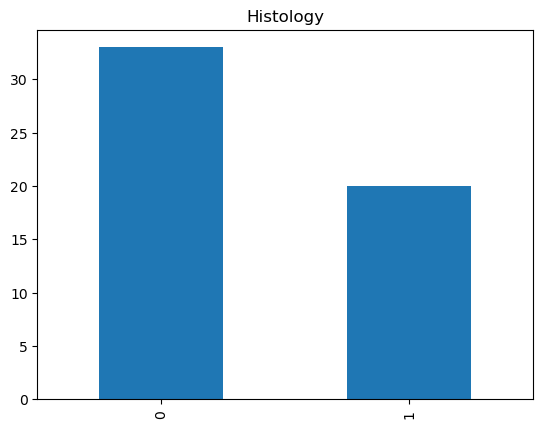

In [37]:
X = X_test.drop(['Case ID','Histology'], axis=1)
y = X_test['Histology']

sm = SMOTE(random_state=73)

# Fit and apply the transform
X_resampled, y_resampled = sm.fit_resample(X, y)
rows_to_drop = X_resampled.index[-13:]  # Get the last 14 indices
X_resampled = X_resampled.drop(rows_to_drop)
rows_to_drop = y_resampled.index[-13:]  # Get the last 14 indices
y_resampled = y_resampled.drop(rows_to_drop)

#concatenate to dataframe
X_resampled_test = pd.DataFrame(X_resampled, columns=X.columns)
X_resampled_test['Histology'] = y_resampled
X_resampled_test['Histology'].value_counts().plot(kind='bar', title='Histology')

In [ ]:
#save csv
X_resampled_train.to_csv('./train_data_resamples.csv', index=False)
X_resampled_test.to_csv('./test_data_resamples.csv', index=False)